In [6]:
import numpy as np
from sklearn.datasets import make_regression
import catboost
from joblib import load 
import pandas as pd
from os.path import join
import time 
import onnxruntime as rt


In [7]:
def time_it(model_name, model, X,iters=10,onnx=False):
    res = []
    if not onnx:
        for i in range(iters):
            tic = time.time()
            pred = model.predict(X)
            toc = time.time()
            res.append((toc - tic))
            
    return pd.DataFrame({'model':model_name, 'time':res})


def time_it_onnx(sess,label_name, input_name, model_name,iter=10):
    res = []
    for i in range(iter):
        tic = time.time()
        predictions = sess.run([label_name],
                          {input_name:  X.astype(np.float32)})
        toc = time.time()
        res.append((toc - tic))
    return pd.DataFrame({'model':model_name, 'time':res})
    

In [8]:
models_path = 'models'


df_list = []


In [9]:
print (rt.get_device())
print (rt.get_available_providers())
#print (rt.get_all_providers())

CPU
['CPUExecutionProvider']


In [10]:
# Generación del dataset
n_samples = 10000
n_features = 40
X, y = make_regression(n_samples=n_samples, n_features=n_features, random_state=0)

In [11]:
lr = load(join(models_path,'lr.joblib'))
cat_model =  load(join(models_path,'catb.joblib'))
rf_model = load(join(models_path,'rf.joblib'))

/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LinearRegression from version 1.1.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.2.1. This might lead to breaking c

In [12]:
lr_results = time_it('lr', lr, X,iters=10)
df_list.append(lr_results)
lr_results

,model,time
0,lr,0.003421
1,lr,0.001483
2,lr,0.000708
3,lr,0.000992
4,lr,0.000667
5,lr,0.000618
6,lr,0.000653
7,lr,0.000676
8,lr,0.000583
9,lr,0.000722


In [13]:
cat_results = time_it('cat_model', cat_model, X,iters=10)
df_list.append(cat_results)

cat_results

,model,time
0,cat_model,0.173290
1,cat_model,0.117892
2,cat_model,0.199824
3,cat_model,0.120099
4,cat_model,0.122509
5,cat_model,0.120659
6,cat_model,0.136752
7,cat_model,0.155355
8,cat_model,0.130421
9,cat_model,0.134823


In [14]:
rf_results = time_it('rf_model', rf_model, X,iters=10)
df_list.append(rf_results)
rf_results

,model,time
0,rf_model,0.121000
1,rf_model,0.144493
2,rf_model,0.194415
3,rf_model,0.166226
4,rf_model,0.114847
5,rf_model,0.114534
6,rf_model,0.112788
7,rf_model,0.113985
8,rf_model,0.113424
9,rf_model,0.113919


# ONNX Inference

In [15]:
sess = rt.InferenceSession(join(models_path,'catb.onnx'),providers=['CPUExecutionProvider'])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
model_name = 'cat_onnx'

cat_results_onnx = time_it_onnx(sess,label_name, input_name, model_name,iter=10)
df_list.append(cat_results_onnx)
cat_results_onnx



2023-02-15 13:02:44.838391618 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {-1} does not match actual shape of {10000,1} for output predictions
2023-02-15 13:02:45.192006395 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {-1} does not match actual shape of {10000,1} for output predictions
2023-02-15 13:02:45.531888201 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {-1} does not match actual shape of {10000,1} for output predictions
2023-02-15 13:02:46.127594273 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {-1} does not match actual shape of {10000,1} for output predictions
2023-02-15 13:02:46.557896099 [W:onnxruntime:, execution_frame.cc:835 VerifyOutputSizes] Expected shape from model of {-1} does not match actual shape of {10000,1} for output predictions
2023-02-15 13:02:46.985620892 [W:onnxruntime:, execution_frame.cc

,model,time
0,cat_onnx,0.353943
1,cat_onnx,0.339747
2,cat_onnx,0.595558
3,cat_onnx,0.430713
4,cat_onnx,0.427727
5,cat_onnx,0.397543
6,cat_onnx,0.382802
7,cat_onnx,0.351376
8,cat_onnx,0.345619
9,cat_onnx,0.354608


In [16]:
sess = rt.InferenceSession(join(models_path,'rf.onnx'))

input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

model_name = 'rf_onnx'

rf_results_onnx = time_it_onnx(sess,label_name, input_name, model_name,iter=10)
df_list.append(rf_results_onnx)

rf_results_onnx

,model,time
0,rf_onnx,0.138658
1,rf_onnx,0.139825
2,rf_onnx,0.140248
3,rf_onnx,0.169794
4,rf_onnx,0.120913
5,rf_onnx,0.121533
6,rf_onnx,0.117862
7,rf_onnx,0.140280
8,rf_onnx,0.123841
9,rf_onnx,0.118253


In [17]:
sess = rt.InferenceSession(join(models_path,'lr.onnx'))


input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

model_name = 'lr_onnx'

lr_results = time_it_onnx(sess,label_name, input_name, model_name,iter=10)
df_list.append(lr_results)
lr_results

,model,time
0,lr_onnx,0.001767
1,lr_onnx,0.000985
2,lr_onnx,0.000645
3,lr_onnx,0.001220
4,lr_onnx,0.000515
5,lr_onnx,0.000406
6,lr_onnx,0.000360
7,lr_onnx,0.000356
8,lr_onnx,0.000358
9,lr_onnx,0.000338


In [18]:
metrics = pd.concat(df_list)

In [19]:
metrics.groupby('model').mean()


,time
model,
cat_model,0.141162
cat_onnx,0.397964
lr,0.001052
lr_onnx,0.000695
rf_model,0.130963
rf_onnx,0.133121


<AxesSubplot: xlabel='model'>

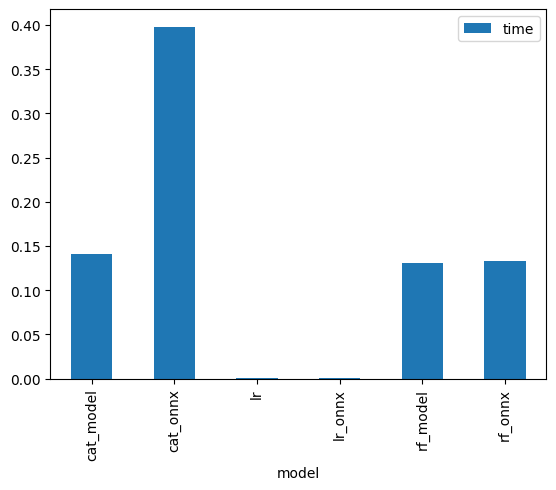

In [21]:
# make a barplot 
metrics.groupby('model').mean().plot(kind='bar')